In [1]:
import os
import warnings
from sys import path

import matplotlib.pyplot as plt
import numpy as np

import dowhy
import dowhy.causal_estimators.linear_regression_estimator
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from dowhy import CausalModel
from sklearn.ensemble import RandomForestRegressor

for dirname, _, filenames in os.walk("../../../resources/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path.append(os.path.realpath("../../../"))

from custom import functions

warnings.filterwarnings("ignore")

# Read and preview data
df = pd.read_csv(
    "../../../resources/v2_hitosExitoFalloColESol1.csv",
    delimiter=";",
    skipinitialspace=True,
)

# creando columna aprobado y con la funcion set_in_aprobado_nota poblamos la nueva columna.
df["aprobado"] = df.apply(lambda x: functions.set_in_aprobado_nota(x["sol1"]), axis=1)
# revisamos la existencia de la nueva columna.
print(df.columns)

../../../resources/allColProSol.xlsx
../../../resources/dataset_a_2021.csv
../../../resources/dataset_a_2021c2.csv
../../../resources/dataset_a_2021v1.xlsx
../../../resources/dataset_unab_ORIGINAL SIN P1.csv
../../../resources/dataset_unab_P1.csv
../../../resources/exitoFallidoEnviosProgramaSol.xlsx
../../../resources/exitoFallidoProgramaSol.xlsx
../../../resources/exitosoFallidosEnviosAllColProSol.xlsx
../../../resources/exitosoFallidosEnviosAllColSol.xlsx
../../../resources/exitososFallidosEnviosSol.xlsx
../../../resources/Hito12sinColCeroExitosoFallidosSol.xlsx
../../../resources/sinColCeroExitosoFallidosEnviosSol.xlsx
../../../resources/sinColCeroExitosoFallidosSol.xlsx
../../../resources/v2_hitosExitoFalloColESol1.csv
../../../resources/v2_hitosExitoFalloColESol1Prograna.csv
../../../resources/v2_hitosExitoFalloSol1Programa.csv
../../../resources/causalidad\causalidad.dot
../../../resources/causalidad\causalidad.png
../../../resources/causalidad\causalidad_e29.dot
../../../resourc

In [2]:
# Array preguntasGuia
preguntasGuia = [
    "e42",
    "e35",
    "e32",
    "e29",
    "e26",
    "e25",
    "e23",
    "e22",
    "e18",
    "e17",
    "e13",
    "e10",
    "e8",
    "e7",
    "e4",
    "e3",
    "e0",
]
outcome_variable = "aprobado"
# Lista para almacenar los resultados
results = []

In [3]:
def run_causal_model(treatment_variable, outcome_variable):
    # Paso 1: Modelar un problema causal
    model = CausalModel(
        data=df,
        treatment=treatment_variable,
        outcome=outcome_variable,
        graph="""
        digraph {
            e42 -> exitosos;
            e42 -> fallidos;
            e42 -> hito1;
            e29 -> exitosos;
            e29 -> fallidos;
            e29 -> hito1;
            e3 -> exitosos;
            e3 -> fallidos;
            e3 -> hito1;
            e35 -> exitosos;
            e35 -> fallidos;
            e35 -> hito1;
            e13 -> exitosos;
            e13 -> fallidos;
            e13 -> hito1;
            e26 -> exitosos;
            e26 -> fallidos;
            e26 -> hito1;
            e18 -> exitosos;
            e18 -> fallidos;
            e18 -> hito1;
            e32 -> exitosos;
            e32 -> fallidos;
            e32 -> hito1;
            e10 -> exitosos;
            e10 -> fallidos;
            e10 -> hito1;
            e0 -> exitosos;
            e0 -> fallidos;
            e0 -> hito1;
            e4 -> exitosos;
            e4 -> fallidos;
            e4 -> hito1;
            e23 -> exitosos;
            e23 -> fallidos;
            e23 -> hito1;
            e7 -> exitosos;
            e7 -> fallidos;
            e7 -> hito1;
            e17 -> exitosos;
            e17 -> fallidos;
            e17 -> hito1;
            e25 -> exitosos;
            e25 -> fallidos;
            e25 -> hito1;
            e22 -> exitosos;
            e22 -> fallidos;
            e22 -> hito1;
            e8 -> exitosos;
            e8 -> fallidos;
            e8 -> hito1;
            fallidos -> exitosos;
            exitosos -> aprobado; 
        }
        """,
    )

    # Paso 2: Identificar el estimando objetivo bajo el modelo
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    # print(identified_estimand)

    # Paso 3: Estimar el efecto causal usando un método basado en árboles
    estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.econml.dml.DML",
        control_value=0,
        treatment_value=1,
        target_units="ate",  # Average Treatment Effect
        method_params={
            "init_params": {
                "model_y": RandomForestRegressor(),
                "model_t": RandomForestRegressor(),
                "model_final": RandomForestRegressor(
                    max_depth=10,
                    min_samples_split=10,
                    min_samples_leaf=5,
                    random_state=1502,
                    n_estimators=500,
                ),
                "featurizer": None,
            },
            "fit_params": {},
        },
    )

    # print("----------------------------")
    # print("Estimado de efecto causal:")
    # print(estimate.value)
    # print("----------------------------")

    # Refutador de datos aleatorios
    refute1 = model.refute_estimate(
        identified_estimand, estimate, method_name="random_common_cause"
    )
    # print(refute1)

    # Refutador de causa común no observada
    refute2 = model.refute_estimate(
        identified_estimand,
        estimate,
        method_name="add_unobserved_common_cause",
        confounders_effect_on_treatment="binary_flip",
        confounders_effect_on_outcome="binary_flip",
        effect_strength_on_treatment=0.01,
        effect_strength_on_outcome=0.02,
    )
    # print(refute2)

    # Paso 4: Refutar el estimado obtenido
    refute3 = model.refute_estimate(
        identified_estimand,
        estimate,
        method_name="placebo_treatment_refuter",
        placebo_type="permute",
    )
    # print(refute3)

    # Paso 5: Natural direct effect (nde)
    identified_estimand_nde = model.identify_effect(
        estimand_type="nonparametric-nde",
        proceed_when_unidentifiable=True,
    )
    # print(identified_estimand_nde)

    causal_estimate_nde = model.estimate_effect(
        identified_estimand_nde,
        method_name="mediation.two_stage_regression",
        confidence_intervals=False,
        test_significance=False,
        method_params={
            "first_stage_model": dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
            "second_stage_model": dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
        },
    )
    # print(causal_estimate_nde)

    # Paso 6: Natural indirect effect (nie)
    identified_estimand_nie = model.identify_effect(
        estimand_type="nonparametric-nie", proceed_when_unidentifiable=True
    )
    # print(identified_estimand_nie)

    causal_estimate_nie = model.estimate_effect(
        identified_estimand_nie,
        method_name="mediation.two_stage_regression",
        confidence_intervals=False,
        test_significance=False,
        method_params={
            "first_stage_model": dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
            "second_stage_model": dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
        },
    )
    # print(causal_estimate_nie)
    print("fin: " + str(treatment_variable))

    # Asegúrate de devolver cualquier resultado que desees almacenar
    return {
        "Variable de Tratamiento": treatment_variable,
        "Variable de Resultado": outcome_variable,
        "Estimación del Efecto Causal": estimate.value,
        "Tipo (Causa Común Aleatoria)": refute1.refutation_type,
        "CCA Efecto Estimado": refute1.estimated_effect,
        "CCA - Nuevo Efecto": refute1.new_effect,
        "CCA - Valor p": refute1.refutation_result["p_value"],
        "Tipo (Causa Común No Observada)": refute2.refutation_type,
        "CCNO - Efecto Estimado": refute2.estimated_effect,
        "CCNO - Nuevo Efecto": refute2.new_effect,
        "Tipo (Tratamiento Placebo)": refute3.refutation_type,
        "TP - Efecto Estimado": refute3.estimated_effect,
        "TP - Nuevo Efecto": refute3.new_effect,
        "TP - Valor p": refute3.refutation_result["p_value"],
        "Efecto Directo Natural (NDE)": causal_estimate_nde.value,
        "Efecto Indirecto Natural (NIE)": causal_estimate_nie.value,
    }

In [4]:
# Iterar sobre cada variable en preguntasGuia
for pregunta in preguntasGuia:
    result = run_causal_model(pregunta, outcome_variable)
    results.append(result)

fin: e42
fin: e35
fin: e32
fin: e29
fin: e26
fin: e25
fin: e23
fin: e22
fin: e18
fin: e17
fin: e13
fin: e10
fin: e8
fin: e7
fin: e4
fin: e3
fin: e0


In [5]:
# Convertir los resultados en un DataFrame para visualizarlos en una tabla
results_df = pd.DataFrame(results)

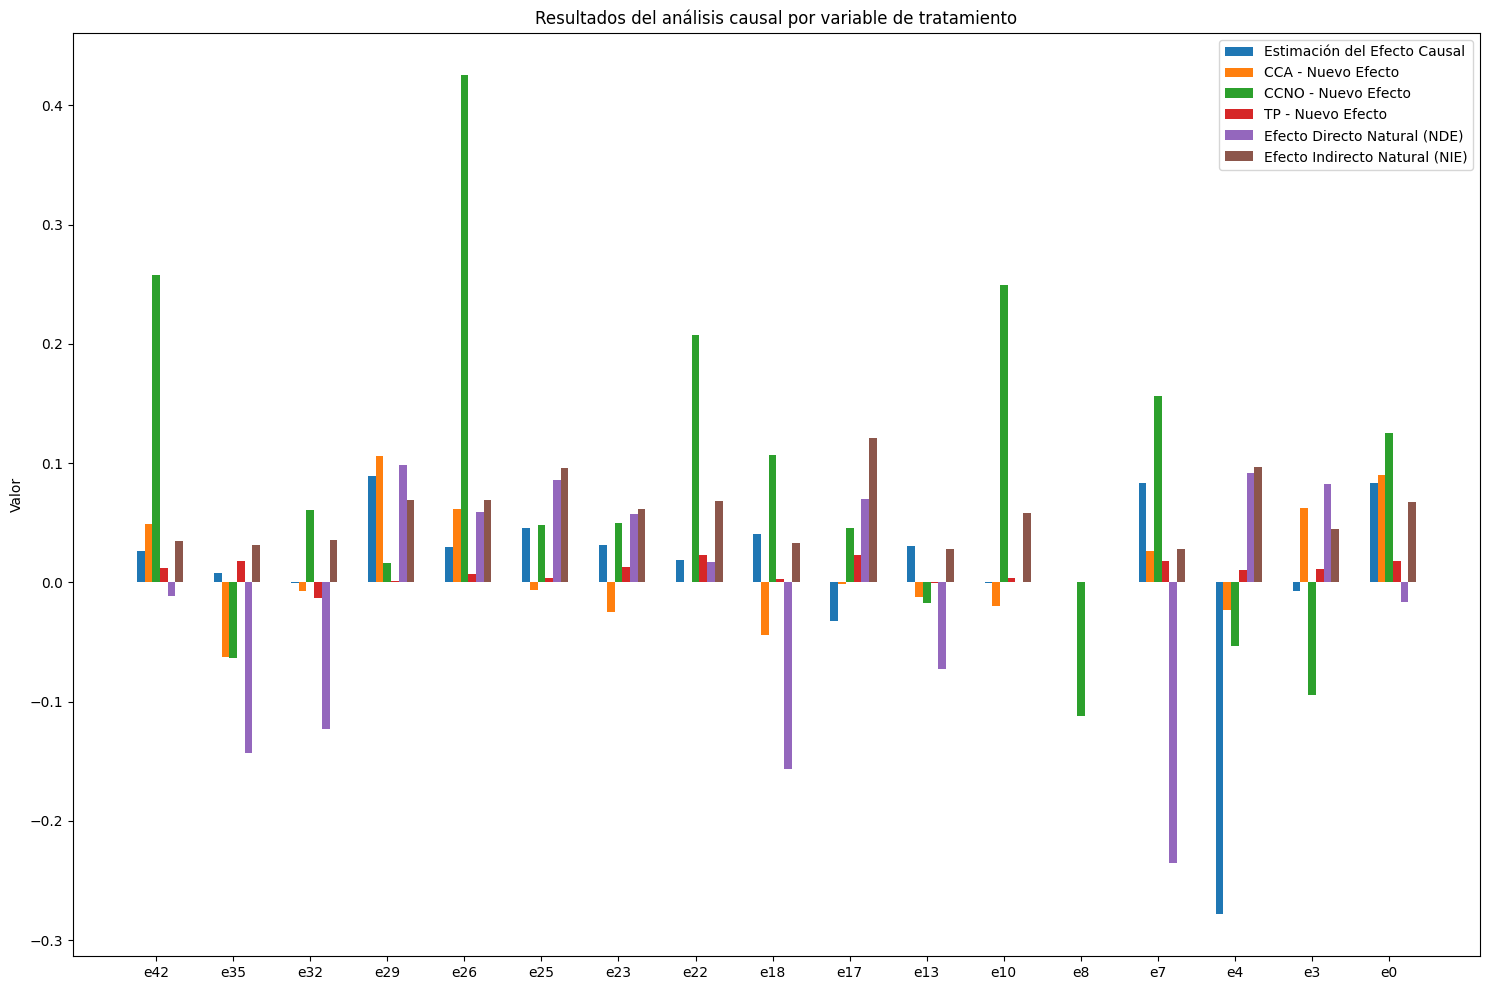

In [6]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(15, 10))

# Crear un rango de valores x para cada variable de tratamiento
x = np.arange(len(results_df["Variable de Tratamiento"]))

# Ancho de las barras
width = 0.1

# Crear gráficos de barras para cada métrica
plt.bar(
    x - 2 * width,
    results_df["Estimación del Efecto Causal"],
    width,
    label="Estimación del Efecto Causal",
)
plt.bar(x - width, results_df["CCA - Nuevo Efecto"], width, label="CCA - Nuevo Efecto")
plt.bar(x, results_df["CCNO - Nuevo Efecto"], width, label="CCNO - Nuevo Efecto")
plt.bar(x + width, results_df["TP - Nuevo Efecto"], width, label="TP - Nuevo Efecto")
plt.bar(
    x + 2 * width,
    results_df["Efecto Directo Natural (NDE)"],
    width,
    label="Efecto Directo Natural (NDE)",
)
plt.bar(
    x + 3 * width,
    results_df["Efecto Indirecto Natural (NIE)"],
    width,
    label="Efecto Indirecto Natural (NIE)",
)

# Añadir etiquetas, título, leyenda, etc.
plt.ylabel("Valor")
plt.title(
    "Resultados del análisis causal por variable de tratamiento" + outcome_variable
)
plt.xticks(x, results_df["Variable de Tratamiento"])
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [7]:
# Ver los resultados
print("Resultados finales en df")
print(results_df)

Resultados finales en df
   Variable de Tratamiento Variable de Resultado  \
0                      e42              aprobado   
1                      e35              aprobado   
2                      e32              aprobado   
3                      e29              aprobado   
4                      e26              aprobado   
5                      e25              aprobado   
6                      e23              aprobado   
7                      e22              aprobado   
8                      e18              aprobado   
9                      e17              aprobado   
10                     e13              aprobado   
11                     e10              aprobado   
12                      e8              aprobado   
13                      e7              aprobado   
14                      e4              aprobado   
15                      e3              aprobado   
16                      e0              aprobado   

    Estimación del Efecto Causal      